# Sequential data engineering Kevin

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from Modules import *
sns.set()
%matplotlib inline

In [2]:
df, y = read_data('../default_of_credit_card_clients.xls')
df = proc_cat_df(df)


df.head().T

,1,2,3,4,5
LIMIT_BAL,20000,120000,90000,50000,50000
AGE,24,26,34,37,57
PAY_1,2,-1,0,0,-1
PAY_2,2,2,0,0,0
PAY_3,-1,0,0,0,-1
PAY_4,-1,0,0,0,0
PAY_5,-2,0,0,0,0
PAY_6,-2,2,0,0,0
BILL_AMT1,3913,2682,29239,46990,8617
BILL_AMT2,3102,1725,14027,48233,5670


## Sequential Data Feature Engineering

In the following code, we will engineer some new features based on the sequential information given in the PAY_AMT and BILL_AMT columns.

First, we calculate the amount of outstanding balance remaining for a client after he/she has payed a bill. This is simply the difference of a bill amount for a time period and the amount payed for that time period.

In [3]:
# created new feature OUTSTANDING_BAL for each period

df["OUTSTANDING_BAL1"] = (df.BILL_AMT1 - df.PAY_AMT1)
df["OUTSTANDING_BAL2"] = (df.BILL_AMT2 - df.PAY_AMT2)
df["OUTSTANDING_BAL3"] = (df.BILL_AMT3 - df.PAY_AMT3)
df["OUTSTANDING_BAL4"] = (df.BILL_AMT4 - df.PAY_AMT4)
df["OUTSTANDING_BAL5"] = (df.BILL_AMT5 - df.PAY_AMT5)
df["OUTSTANDING_BAL6"] = (df.BILL_AMT6 - df.PAY_AMT6)



Next, we'll create new logical variables; these will indicate whether the outstanding balance value has increased (1) or not (0) from the previous period.

In [4]:
#create logical variable: 
#if the outstanding balance for period t-1 is less than period t: 0
#if the outstanding balance for perriod t-1 is more than period t: 1

lst1 = ['OUTSTANDING_BAL1','OUTSTANDING_BAL2', 'OUTSTANDING_BAL3', 'OUTSTANDING_BAL4','OUTSTANDING_BAL5']
lst2 = ['OUTSTANDING_BAL2','OUTSTANDING_BAL3', 'OUTSTANDING_BAL4', 'OUTSTANDING_BAL5','OUTSTANDING_BAL6',]
for idx, (column1, column2) in enumerate(zip(lst1, lst2)):
    idx += 1
    df[f"OUSTANDING_BAL_{idx}_INDICATOR"] = np.where(df[column1] > df[column2], 1, 0)


#possible idea: do a ratio of how much your outstanding balance grew from t-1 to t ((new-old)/old)

Now, we'll do a similar process for the following: we'll calculate a ratio of how much a client's outstanding balance compares to his or her LIMIT_BAL of the account. Then we'll again create a logical variable indicating whether the balance of the current time period has increased (1) or not (0) from the previous time period.

In [5]:
#created new column %_LIMIT_BAL for each month
#oustanding balance of period t divided by LIMIT_BAL 
#how close is a client reaching that LIMIT_BAL limit?

df["PERCENT_OF_LIMIT_BAL1"] = (df.OUTSTANDING_BAL1 / df.LIMIT_BAL)
df["PERCENT_OF_LIMIT_BAL2"] = (df.OUTSTANDING_BAL2 / df.LIMIT_BAL)
df["PERCENT_OF_LIMIT_BAL3"] = (df.OUTSTANDING_BAL3 / df.LIMIT_BAL)
df["PERCENT_OF_LIMIT_BAL4"] = (df.OUTSTANDING_BAL4 / df.LIMIT_BAL)
df["PERCENT_OF_LIMIT_BAL5"] = (df.OUTSTANDING_BAL5 / df.LIMIT_BAL)
df["PERCENT_OF_LIMIT_BAL6"] = (df.OUTSTANDING_BAL6 / df.LIMIT_BAL)



In [6]:
#if the outstanding balance for period t-1 is less than period t: 0
#if the outstanding balance for perriod t-1 is more than period t: 1

lst1 = ['PERCENT_OF_LIMIT_BAL1', 'PERCENT_OF_LIMIT_BAL2', 'PERCENT_OF_LIMIT_BAL3', 'PERCENT_OF_LIMIT_BAL4', 'PERCENT_OF_LIMIT_BAL5']
lst2 = ['PERCENT_OF_LIMIT_BAL2', 'PERCENT_OF_LIMIT_BAL3', 'PERCENT_OF_LIMIT_BAL4', 'PERCENT_OF_LIMIT_BAL5', 'PERCENT_OF_LIMIT_BAL6']
for idx, (column1, column2) in enumerate(zip(lst1, lst2)):
    idx += 1
    df[f"PERCENT_OF_LIMIT_BAL_{idx}_INDICATOR"] = np.where(df[column1] > df[column2], 1, 0)



### what ratio of the bill are they paying?
### similar to oustanding balance, might have to choose

Here, we will calculate what percentage of the bill the client is paying off each time period. Then, we'll create a logical variable indicating whether the ratio of the current time period is increaseing (1) or not (0) compared to the previous time period.

In [7]:
#describe the percentage of the bill that clients are paying
#have to set if a bill amt is 0, will be the same as the previous time periods value
#therefore, have to initialize the the time period, t = 6 values first 

lst1 = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4','BILL_AMT5', 'BILL_AMT6']
lst2 = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3','PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
for idx, (col1, col2) in enumerate(zip(lst1, lst2)):
    idx +=1
    df[f"PAY_RATIO_{idx}"] = np.where(df[col1] != 0, df[col2]/df[col1], 1)


In [8]:
#create the indicator
#if the ratio is increasing across the months we will give them a 1, 0 if is the same or decreasing.

df.loc[df["PAY_RATIO_1"] < df["PAY_RATIO_2"], 'PAY_RATIO_1_INDICATOR'] = (1*(5/5)) 
df.loc[df["PAY_RATIO_1"] >= df["PAY_RATIO_2"], 'PAY_RATIO_1_INDICATOR'] = 0 

df.loc[df["PAY_RATIO_2"] < df["PAY_RATIO_3"], 'PAY_RATIO_2_INDICATOR'] = (1*(4/5))
df.loc[df["PAY_RATIO_2"] >= df["PAY_RATIO_3"], 'PAY_RATIO_2_INDICATOR'] = 0

df.loc[df["PAY_RATIO_3"] < df["PAY_RATIO_4"], 'PAY_RATIO_3_INDICATOR'] = (1*(3/5))
df.loc[df["PAY_RATIO_3"] >= df["PAY_RATIO_4"], 'PAY_RATIO_3_INDICATOR'] = 0 

df.loc[df["PAY_RATIO_4"] < df["PAY_RATIO_5"], 'PAY_RATIO_4_INDICATOR'] = (1*(2/5)) 
df.loc[df["PAY_RATIO_4"] >= df["PAY_RATIO_5"], 'PAY_RATIO_4_INDICATOR'] = 0

df.loc[df["PAY_RATIO_5"] < df["PAY_RATIO_6"], 'PAY_RATIO_5_INDICATOR'] = (1*(1/5)) 
df.loc[df["PAY_RATIO_5"] >= df["PAY_RATIO_6"], 'PAY_RATIO_5_INDICATOR'] = 0

In [9]:
df.head().T

,1,2,3,4,5
LIMIT_BAL,20000.000000,120000.000000,90000.000000,50000.000000,50000.000000
AGE,24.000000,26.000000,34.000000,37.000000,57.000000
PAY_1,2.000000,-1.000000,0.000000,0.000000,-1.000000
PAY_2,2.000000,2.000000,0.000000,0.000000,0.000000
PAY_3,-1.000000,0.000000,0.000000,0.000000,-1.000000
PAY_4,-1.000000,0.000000,0.000000,0.000000,0.000000
PAY_5,-2.000000,0.000000,0.000000,0.000000,0.000000
PAY_6,-2.000000,2.000000,0.000000,0.000000,0.000000
BILL_AMT1,3913.000000,2682.000000,29239.000000,46990.000000,8617.000000
BILL_AMT2,3102.000000,1725.000000,14027.000000,48233.000000,5670.000000


In [18]:
# put to a csv

df.to_csv('sequential_data.csv')

## Evaluate

Using the same evaluation code as the data with no such feature engineering, we'll evaluate whether the new features increase the model's performance.

In [13]:
evaluate_baseline(df)

[0.38104839 0.36777583 0.37029604 0.38820267 0.38052209 0.36864728
 0.78567553 0.97474302 0.9780445  0.97729603]

corss-validation f1 score: 0.5972251378362949


In [14]:
df.columns

Index(['LIMIT_BAL', 'AGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'Y', 'SEX_Female', 'SEX_Male',
       'EDUCATION_Graduate School', 'EDUCATION_Other', 'EDUCATION_University',
       'MARRIAGE_Married', 'MARRIAGE_Non-married', 'OUTSTANDING_BAL1',
       'OUTSTANDING_BAL2', 'OUTSTANDING_BAL3', 'OUTSTANDING_BAL4',
       'OUTSTANDING_BAL5', 'OUTSTANDING_BAL6', 'OUSTANDING_BAL_1_INDICATOR',
       'OUSTANDING_BAL_2_INDICATOR', 'OUSTANDING_BAL_3_INDICATOR',
       'OUSTANDING_BAL_4_INDICATOR', 'OUSTANDING_BAL_5_INDICATOR',
       'PERCENT_OF_LIMIT_BAL1', 'PERCENT_OF_LIMIT_BAL2',
       'PERCENT_OF_LIMIT_BAL3', 'PERCENT_OF_LIMIT_BAL4',
       'PERCENT_OF_LIMIT_BAL5', 'PERCENT_OF_LIMIT_BAL6',
       'PERCENT_OF_LIMIT_BAL_1_INDICATOR', 'PERCENT_OF_LIMIT_BAL_2_INDICATOR',
       'PERCENT_OF_LIMIT_BAL_3_INDICATO

In [17]:
#drop the features that are used in calculating other features

df_no = df.drop(columns = ['OUTSTANDING_BAL1',
       'OUTSTANDING_BAL2', 'OUTSTANDING_BAL3', 'OUTSTANDING_BAL4',
       'OUTSTANDING_BAL5', 'OUTSTANDING_BAL6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'])

evaluate_baseline(df_no)

[0.37235811 0.36398285 0.36311651 0.37597911 0.37488152 0.35798038
 0.7886236  0.99220554 0.99423797 0.99220554]

corss-validation f1 score: 0.5975571130144623


In [10]:
results = XGBoost_evaluate(df)

Text(15,0.88,'final auc-mean score: 0.9365739999999999')

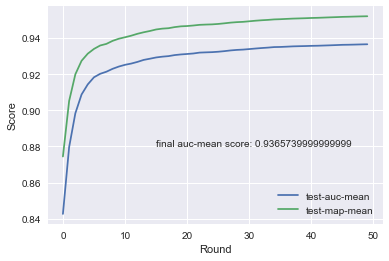

In [13]:
results[['test-auc-mean', 'test-map-mean']].plot()
plt.xlabel('Round')
plt.ylabel('Score')
plt.annotate(xy = (15,.88), s='final auc-mean score: ' +str(results['test-auc-mean'][49]))